In [1]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


## Practical approach: ODEs vs PDEs

+ ODEs you can usually get away with using built-in integration functions, unless you have a special type of equation (delay, integro-differential, etc.)
+ In my experience, you rarely have the same luck with PDEs. You usually have to write your own discretization and solver. 
+ If you are solving a very common PDE (Navier Stokes, Laplace, etc.) there might be external libraries that work in certain regimes, or which can help with meshing, etc. But even in very restricted regimes, the design of these tools is expensive and narrow (using Ansys, COMSOL, etc. is a whole specialization in itself)



# Boundary conditions

+ The boundary conditions are the conditions on the solution at the boundary of the domain, whether the domain is space or time
+ The boundary conditions are usually specified as a function of the independent variable(s) (e.g. time or space) on a subset of the domain

+ For our examples so far, we've specified the boundary conditions as $u(\mathbf{x}, t) = u_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$, where $\Omega$ denotes our solution domain (square, disk, etc). These are known as *Dirichlet* boundary conditions, where we specify the value of $u$ at the boundary.
+ We can also have *Neumann* boundary conditions, where we specify the value of the derivative of $u$ at the boundary. For example, we could specify $\nabla u(\mathbf{x}, t) \cdot \mathbf{\hat{t}} = f_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$, where $\mathbf{\hat{t}}$ is a unit vector normal to the boundary. This type of boundary condition specifies a fixed flux of the scalar field through the boundary.
+ We can also have *mixed* or Robin boundary conditions, where we specify a combination of Dirichlet and Neumann boundary conditions. $u(\mathbf{x}, t) + \nabla u(\mathbf{x}, t) \cdot \mathbf{\hat{t}}  = g_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$.



<!-- ## The Diffusion Equation

+ A differential equation that is often used to model the diffusion of a quantity through a medium
+ Appears in many contexts, including heat transfer, fluid flow, diffusion of molecules
+ Even the Schrodinger equation is a special case of the diffusion equation
+ Given a scalar field $\rho(x)$, the diffusion equation is

$$\frac{\partial \rho}{\partial t} = \nabla^2 \rho$$
 -->


# Burgers' equation

+ A nonlinear partial differential equation describing the time evolution of a fluid

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}$$

+ The solutions tend to evolve towards shocks, which are discontinuities in the velocity


#  Semi-discretization: The Method of lines

+ Discretize the domain using finite differences, spectral projection, or something else, and then solve the resulting set of coupled ODEs in continuous time using a built-in ODE solver
+ The semi-discretized PDE is a set of coupled ODEs in continuous time
+ The semi-discretized PDE is usually solved using a built-in ODE solver


## One possible discretization: Finite difference operators

The finite difference operators are the operators that we use to approximate the derivatives in the PDE

The central first-order finite difference operators in 1D has the form

$$\frac{\partial}{\partial x} \approx \frac{f(x + \Delta x / 2) - f(x - \Delta x / 2)}{\Delta x}$$

The central second-order finite difference operators in 1D has the form

$$\frac{\partial^2}{\partial x^2} \approx \frac{f(x + \Delta x) - 2 f(x) + f(x - \Delta x)}{\Delta x^2}$$

## Semi-discretized Burgers' equation

Using the finite-different approximations to approximate the spatial derivatives, Burgers' equation becomes

$$\frac{\partial u}{\partial t} \approx \frac{u(x + \Delta x) - 2 u(x) + u(x - \Delta x)}{\Delta x^2} - u(x) \frac{u(x + \Delta x) - u(x - \Delta x)}{2 \Delta x}$$

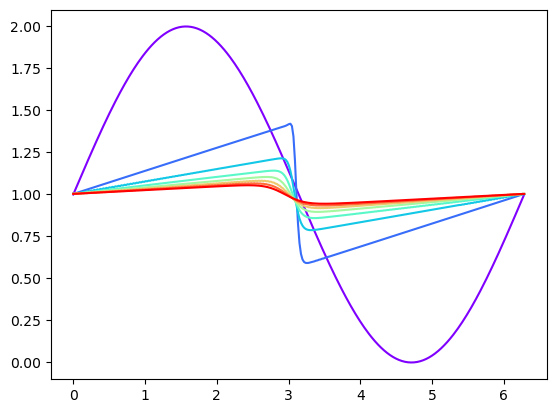

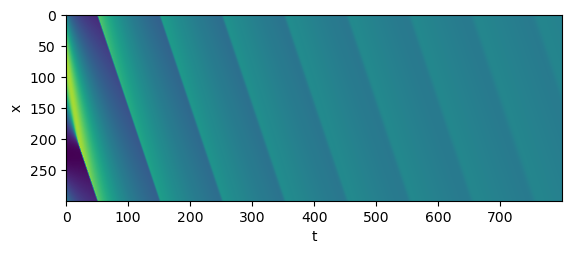

In [251]:
class BurgersEquation:

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

    def _derivative(self, u):
        du = u.copy()
        # central finite difference
        du[1:-1] = (u[2:] - u[:-2]) / (2 * self.dx)

        ## Periodic boundary conditions
        du[0] = (u[1] - u[-1]) / self.dx
        du[-1] = (u[0] - u[-2]) / self.dx

        ## Enforce reflection boundary conditions
        # du[0] = 0
        # du[-1] = 0

        # Enforce zero Dirichlet boundary conditions
        # du[0] = (u[1] - 0) / self.dx
        # du[-1] = (0 - u[-1]) / self.dx

        return du

    def _laplacian(self, u):
        ddu = u.copy()
        ddu[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / self.dx**2

        ## Periodic boundary conditions with differences
        ddu[0] = (u[1] - 2 * u[0] + u[-1]) / self.dx**2
        ddu[-1] = (u[0] - 2 * u[-1] + u[-2]) / self.dx**2

        # ## Enforce reflection boundary conditions
        # ddu[0] = (u[1] - 2 * u[0] + u[1]) / self.dx**2
        # ddu[-1] = (u[-2] - 2 * u[-1] + u[-2]) / self.dx**2

        ## Enforce zero Dirichlet boundary conditions
        # ddu[0] = (u[1] - 2 * u[0] + 0) / self.dx**2
        # ddu[-1] = (0 - 2 * u[0] + u[-1]) / self.dx**2

        return ddu

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)



x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 800)
u0 = 1 + np.sin(x)

# u0 = 1 - np.cos(x) # need to pick an initial condition consistent with boundary conditions

eq = BurgersEquation(x, t, u0)

from scipy.integrate import solve_ivp
sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t)

# plot with colormap for time
colors = plt.cm.rainbow(np.linspace(0, 1, len(sol.y[:, ::100].T)))
for i, sol0 in enumerate(sol.y[:, ::100].T):
    plt.plot(x, sol0, color=colors[i])
plt.show()

plt.imshow(sol.y)
plt.xlabel('t')
plt.ylabel('x')
plt.show()


1. Try playing with the parameters $\nu$ and $\Delta x$ to see how the solution evolves. What causes the shocks to live longer?
2. Try changing the initial condition to a Gaussian. What happens?
3. Try changing the boundary conditions to reflective (Neumann) or Dirichlet. What happens?

## The CFL condition for hyperbolic PDEs

+ The Courant–Friedrichs–Lewy (CFL) condition is a condition on mesh size and the time step that must be satisfied for the numerical solution of a hyperbolic PDE to be stable
+ Suppose that we have the wave equation in one dimension:

$$\frac{\partial^2 \rho}{\partial t^2} = c^2 \frac{\partial^2 \rho}{\partial x^2}$$

where $c$ determines the speed of travelling waves. A full discretization of this equation in space and time would be

$$\frac{\rho(x, t + \Delta t) - 2 \rho(x, t) + \rho(x, t - \Delta t)}{\Delta t^2} = c^2 \frac{\rho(x + \Delta x, t) - 2 \rho(x, t) + \rho(x - \Delta x, t)}{\Delta x^2}$$

The CFL condition determines the maximum value of $\Delta t$ that can be used for a given $\Delta x$ and $c$

$$
c \frac{\Delta t}{\Delta x} \leq C_{max}
$$

+ Where the dimensionless Courant number $C_{max}$ is determined by our iteration scheme. 
+ As a rule of thumb $C_{max} \sim 1$, because $C_{max}$ can be interpreted as the number of mesh cells that a particle of $\rho$ traverses per integration time step (for an Euler time-stepping scheme and fixed mesh size, this is exact). Realistically, we want to stay a little bit below the CFL limit, because we don't want to be right on the edge of instability. A typical "safety factor" would be $0.7$

More info to check out in Chris Rycroft's notes: additional work showing stability conditions for PDE solvers. Fourier modes on a finite mesh, stability occurs  when none of the modes grow exponentially with time. Extremely similar to analytical tools that people use to study Reaction-Diffusion equations (see Murray textbook vol II, chapter 3).

### Applying the CFL condition to Burgers' equation

+ While we typically use the CFL condition here for hyperbolic PDE (wave equations), in practice it's a good rule-of-thumb for PDEs that admit travelling solutions, like solitons or Fisher waves or advance. 
+ Can find $c$ by defining the shape $u(x)$ of your solution wave, and then plugging the travelling solution $u(x - ct)$ into the PDE and solving for $c$
+ For Burgers' equation, we can pick a well-defined speed $c$ associated with the shock. For our parameter choices above, $c \approx 3$.

In [218]:
## Define a fixed step integrator (solve_ivp uses adaptive step size)

class BaseFixedStepIntegrator:
    """
    A base class for fixed-step integration methods.
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y0, t_eval=None):
        """
        Integrate the ODE y' = f(t, y) from t0 to tf using an integrator's update method
        """
        t0, tf = tspan
        # Create an array of time points to evaluate the solution
        if t_eval is None:
            t_eval = np.arange(t0, tf, self.dt)

        # Create an array to store the solution (pre-allocate)
        y = np.zeros((len(t_eval), len(y0)))

        # Set the initial condition
        y[0] = y0

        # Integrate the ODE
        for i in range(1, len(t_eval)):
            t = t_eval[i - 1]
            y[i] = self.update(f, t, y[i - 1]) # this will be defined in the subclass

        self.t, self.y = t_eval, np.array(y)
        return self

    def update(self, f, t, y):
        """
        Update the solution using the integrator's method
        """
        raise NotImplementedError("This method must be implemented in a subclass")
        

class RK4(BaseFixedStepIntegrator):
    """
    The Runge-Kutta 4 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        k3 = f(t + self.dt / 2, y + self.dt * k2 / 2)
        k4 = f(t + self.dt, y + self.dt * k3)
        return y + self.dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

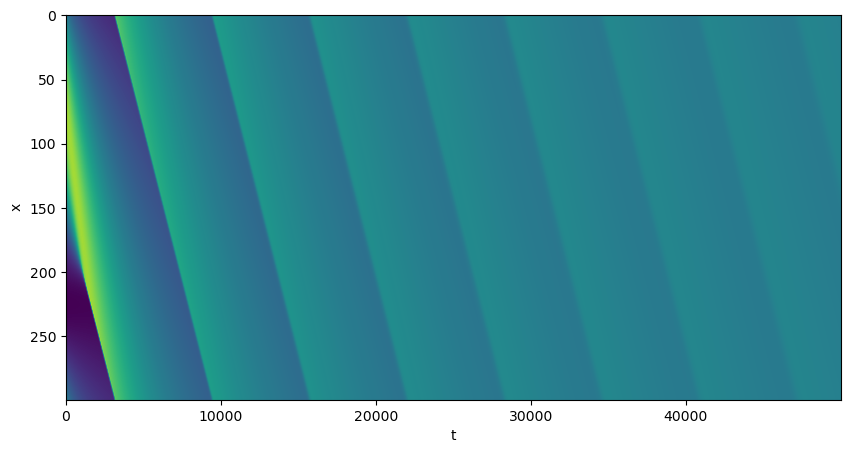

In [225]:
x = np.linspace(0, 2 * np.pi, 300)
u0 = 1 + np.sin(x)
dtval = 0.001
# dtval = 0.1
t = np.arange(0, 50, dtval)

eq = BurgersEquation(x, t, u0)

integrator = RK4(dt=dtval)
sol = integrator.integrate(eq, (t[0], t[-1]), u0, t_eval=t)


## Show results
plt.figure(figsize=(10, 5))
plt.imshow(sol.y.T, aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.show()


In [226]:
## Calculate CFL condition

c = 3

print('CFL number: ', c * dtval / eq.dx)

CFL number:  0.14276198395343012


# Burgers' equation in a spectral basis

+ Instead of defining our mesh in space, we can instead discretize our field by projecting it onto a series of basis functions
+ Our ODEs after discretization will discribe the time evolution of the relative amplitudes of the basis functions
+ This is basically like transforming, and then discretizing in the transformed space


Our original equation is

$$
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}
$$


For simplicity, let's use a Fourier basis. If our domain is $[0, L]$, then the Fourier basis functions are

$$\phi_k(x) = \sqrt{\frac{2}{L}} \sin \left( \frac{2 \pi k x}{L} \right)$$

where $k$ is an integer. The Fourier basis functions are orthonormal, so we can write the solution as a linear combination of the basis functions

$$\rho(x, t) = \sum_{k = -\infty}^{\infty} c_k(t) \phi_k(x)$$

where $c_k(t)$ is the amplitude of the $k$ th Fourier mode at time $t$. We can next recall our rules for the Fourier transform of the derivatives of a function, in order to write the derivatives of the solution in terms of the amplitudes of the Fourier modes

$$\frac{\partial \rho}{\partial t} = \sum_{k = -\infty}^{\infty} i k c_k(t) \phi_k(x)$$

$$\frac{\partial^2 \rho}{\partial x^2} = \sum_{k = -\infty}^{\infty} -k^2 c_k(t) \phi_k(x)$$

<!-- We can use these to write the semi-discretized Burgers' equation in terms of the amplitudes of the Fourier modes

$$\frac{\partial c_k}{\partial t} = -\nu k^2 c_k$$ -->

Upon substituting these terms into the Burgers' equation PDE, we encounter a problem. First, let's consider the first term on the right hand side of the equation. We can write this as

$$\frac{\partial \rho}{\partial t} = \sum_{k = -\infty}^{\infty} i k c_k(t) \phi_k(x)$$

If this term was the only active term (or $\nu \gg 1$), then we would have a diffusion-like equation. In this case, we could write our entire PDE in the spectral domain

$$\frac{\partial c_k}{\partial t} = -\nu k^2 c_k$$

For linear equations like the heat equation, the solution method is extremely simple: convert to the spectral domain, determine the time evolution of the coefficients $c_k(t)$, and then convert back to the physical domain. The modes of the heat equation are decoupled in the spectral domain, so we can solve the ODEs for each mode independently and very efficiently.

# Spectral methods with nonlinear terms

For nonlinear systems like Burgers' equation or reaction-diffusion equations, it's often not possible to convert the entire PDE into a concise spectral form. Instead, we need to "roundtrip" the solution between the physical and spectral domains at every evaluation. This is a bit more complicated, but it's still possible to solve the problem efficiently.

<!-- The semi-discretized PDE is now

$$\frac{\partial \rho_k}{\partial t} = \nu \frac{\partial^2 \rho_k}{\partial x^2}$$

which is a set of coupled ODEs in continuous time. We can solve this using a built-in ODE solver. -->

/Users/william/miniconda3/envs/dedalus3/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


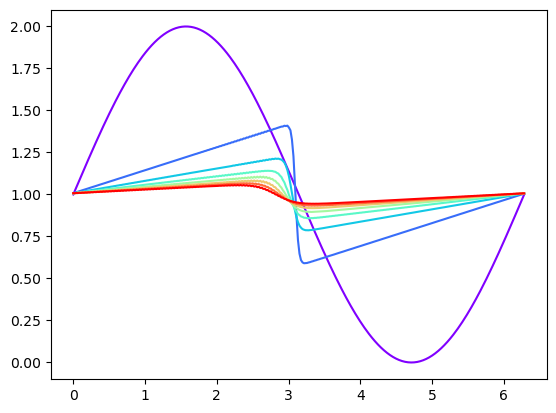

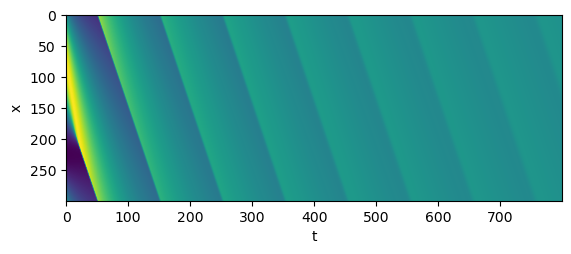

In [159]:
class BurgersEquationSpectral:

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

        self.k = 2 * np.pi * np.fft.fftfreq(len(x), d=self.dx)
        self.k[0] = 1e-16 # avoid division by zero

    def _derivative(self, u):
        return np.fft.ifft(1j * self.k * np.fft.fft(u))

    def _laplacian(self, u):
        return np.fft.ifft(-self.k**2 * np.fft.fft(u))

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)



x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 800)
u0 = 1 + np.sin(x)

eq = BurgersEquationSpectral(x, t, u0)

from scipy.integrate import solve_ivp
sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t)

# plot with colormap for time
colors = plt.cm.rainbow(np.linspace(0, 1, len(sol.y[:, ::100].T)))
for i, sol0 in enumerate(sol.y[:, ::100].T):
    plt.plot(x, sol0, color=colors[i])
plt.show()
plt.show()


plt.imshow(sol.y)
plt.xlabel('t')
plt.ylabel('x')
plt.show()




## What are the appropriate basis functions? 

+ Usually, we pick basis functions that form an orthogonal set, and which are consistent with our boundary conditions
+ So far, we've been using the Fourier basis functions and periodic boundary conditions


## The Chebyshev basis functions

+ For Dirichlet boundary conditions, we can use the Chebyshev basis functions, which are a set of functions that vanish or approach constant values at the boundary
+ The Chebyshev basis functions are a set of orthogonal functions that are defined on the interval $[-1, 1]$
+ The Chebyshev basis functions are defined recursively
$$T_0(x) = 1$$
$$T_1(x) = x$$
$$T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$$

## Legendre basis functions

+ Another option Dirichlet boundary conditions, we can use the Chebyshev basis functions, which are a set of functions that vanish or approach constant values at the boundary
+ The Legendre basis functions are a set of orthogonal functions that are defined on the interval $[-1, 1]$
+ The Legendre basis functions are defined recursively
$$P_0(x) = 1$$
$$P_1(x) = x$$
$$P_{n+1}(x) = \frac{2n+1}{n+1}xP_n(x) - \frac{n}{n+1}P_{n-1}(x)$$




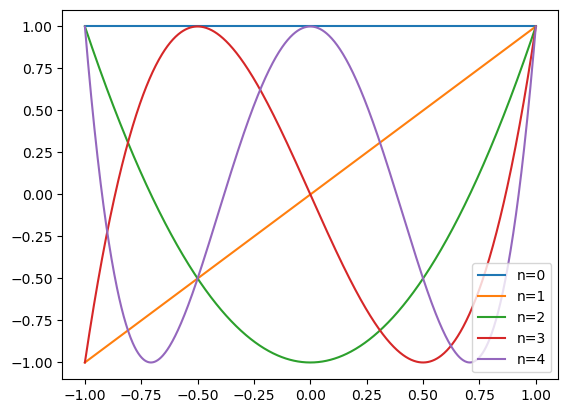

In [36]:
### Plot example Chebyshev polynomials

from scipy.special import eval_chebyt

x = np.linspace(-1, 1, 1000)
for n in range(5):
    plt.plot(x, eval_chebyt(n, x), label=f'n={n}')

plt.legend()
plt.show()


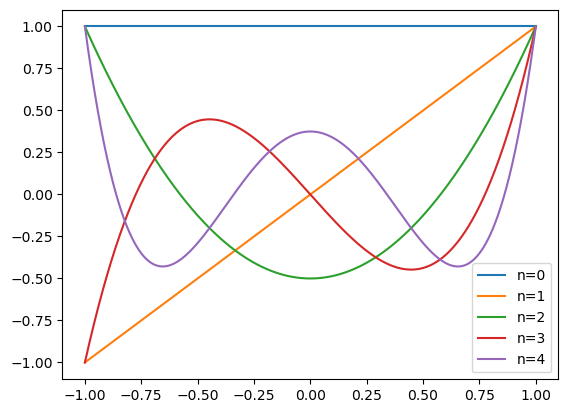

In [37]:
### Plot example Legendre polynomials

from scipy.special import eval_legendre

x = np.linspace(-1, 1, 1000)
for n in range(5):
    plt.plot(x, eval_legendre(n, x), label=f'n={n}')

plt.legend()
plt.show()



# Some specificities of Burgers' equation

+ Shock waves are discontinuities in the velocity, but not in the density
+ The shock wave is a discontinuity in the derivative of the velocity
+ Propagate ballistically, i.e. at a constant speed of sound in the fluid
+ Characteristics: initial conditions get "carried" with the flow


### An even easier solution approach: Transformation onto a linear equation

+ Burgers equation is a nonlinear PDE, but it can be transformed into a linear PDE by introducing a new variable

The Cole-Hopf transformation implies that we can substitute the variable $u(x)$ with $\phi(x)$ using the following defintion
$$
u=-2\nu {\frac {1}{\phi }}{\frac {\partial \phi }{\partial x}}
$$

Inserting this into the viscous Burgers equation gives
$$
{\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial \phi }{\partial t}}\right)=\nu {\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial ^{2}\phi }{\partial x^{2}}}\right)
$$
After some algebraic manipulation, we get
$$
{\frac {\partial \phi }{\partial t}}=\nu {\frac {\partial ^{2}\phi }{\partial x^{2}}}
$$
This is a linear diffusion equation, which we've already seen many methods of solving. We can solve this simplified heat equation, and then cast back into the original variables by performing the inverse transformation
$$
u(x,t)=-2\nu {\frac {\partial }{\partial x}}\ln \left\{(4\pi \nu t)^{-1/2}\int _{-\infty }^{\infty }\exp \left[-{\frac {(x-x')^{2}}{4\nu t}}-{\frac {1}{2\nu }}\int _{0}^{x'}f(x'')dx''\right]dx'\right\}.
$$


#### Takeaway: unlike our chaotic systems, the complexity of the dynamics of the Burgers equation is not intrinsic, but rather due to our choice of dynamical variables

+ Preview of machine learning: is a problem intrinsically hard, or do we just need to pick the right coordinates?

## Appendix

+ This is William's leftover code, which might get used in a future version of the tutorial

In [ ]:
# Solve the KuramotoSivashinsky equation with spectral methods

from scipy.integrate import solve_ivp

class KuramotoSivashinskyEquationSpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


In [ ]:
# https://scicomp.stackexchange.com/questions/37336/solving-numerically-the-1d-kuramoto-sivashinsky-equation-using-spectral-methods
class KuramotoSivashinskySpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]
        self.dt = t[1] - t[0]

        self.k = np.fft.fftfreq(len(x), d=self.dx)
        self.k2 = self.k**2
        self.k4 = self.k**4

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

eq = KuramotoSivashinskySpectral(x, t, u0)
sol = eq.solve()

plt.plot(x, sol[:, 0])
plt.plot(x, sol[:, -1])
plt.show()
